# <a>Demand Predictions for Consumable Retail Products<a>

## <a name=0>Contents <a/>

1. <a href=#1>Problem Statement <a/>

2. <a href=#2>Import Libraries <a/>

3. <a href=#3>Read and Explore Data <a/>
    
4. <a href=#4>Data Visualisations <a/>   

5. <a href=#5>Feature Engineering<a/>   

6. <a href=#6>Train - Validation Split<a/>

7. <a href=#7>Model Building<a/>
    
8. <a href=#8>Test Data Predictions<a/>

## <a name=1>Problem Statement<a/>
<a href=#0>(Go to Contents)<a/>

#### Scenario
A large company that manufactures eatables, delivers them through a group of suppliers to retailers of different kinds all over the country. One of the company’s recent sustainable initiatives was to sell eatable products with no preservatives. These consumables have a shelf life of one week.

The company, to ensure the quality of its products on retailers’ shelves, creates a program to buy back the remaining products on the shelves of the retailers post expiry (one week). This has significantly increased the company’s operation costs and is also affecting its gross margins.

The company has hired you as a data science consultant and provides you with 5 weeks of data. You are now supposed to predict the demand for various products across for the next two weeks. You are also supposed to produce a report using your machine learning model and the 5th week’s data as a validation set to analyze the potential loss in revenue / gain in operational costs.

#### Objectives:
In this hackathon, you are expected to:
1. Generate the target variable ‘demand_projection’
2. Build a machine learning / deep learning model, which should predict the demand projection for the records in the test data
3. Analyze the predictions of the model, using 4 weeks data, to report the loss of revenue for week 5 if the model was deployed

#### Evaluation Metric:
The evaluation metric is the ​Root Mean Squared Error (RMSE)

## <a name=2>Importing libraries<a/>
<a href=#0>(Go to Contents)<a/>

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
import matplotlib.pyplot as plt
%matplotlib inline

To get data files from a google drive

In [ ]:
#from google.colab import drive

#drive.mount('/content/gdrive')

Used Google Colab to run the train data analysis due to computational challenges on local machine.

## <a name=3>Read and Explore data<a/>
<a href=#0>(Go to Contents)<a/>

To get training data file from Google Drive

In [ ]:
#data=pd.read_csv('/content/gdrive/My Drive/train.csv')

To get training data from local directory

In [ ]:
os.getcwd()

In [ ]:
data = pd.read_csv('train.csv', sep = ',')

In [4]:
data.shape

(53364883, 10)

#### Let's drop duplicate samples if any

In [5]:
data=data.drop_duplicates()
data.shape

(53364735, 10)

In [ ]:
data=data.reset_index(drop=True)

#### Check the datatypes

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53364735 entries, 0 to 53364882
Data columns (total 10 columns):
experiment_week                object
channel_type                   object
num_units_sold_in_week         int64
sales_revenue_in_week          float64
num_units_returned             int64
returned_units_revenue_loss    float64
store_identifier               object
product_identifier             object
category_of_route              object
supplier_identifier            object
dtypes: float64(2), int64(2), object(6)
memory usage: 4.4+ GB


**Checking for NA values**

In [ ]:
data.isnull().sum()

experiment_week                0
channel_type                   0
num_units_sold_in_week         0
sales_revenue_in_week          0
num_units_returned             0
returned_units_revenue_loss    0
store_identifier               0
product_identifier             0
category_of_route              0
supplier_identifier            0
dtype: int64

**Let's look at the number of unique entries in each column**

In [ ]:
for i in data.columns:
    print(i)
    print(data[i].nunique())

experiment_week
5
channel_type
9
num_units_sold_in_week
1883
sales_revenue_in_week
69844
num_units_returned
497
returned_units_revenue_loss
13040
store_identifier
587773
product_identifier
1736
category_of_route
3490
supplier_identifier
552


**As Channel type has 9 unique values, we will convert the datatype to Category**

In [ ]:
data.channel_type = data.channel_type.astype('category')

In [ ]:
data.dtypes

experiment_week                  object
channel_type                   category
num_units_sold_in_week            int64
sales_revenue_in_week           float64
num_units_returned                int64
returned_units_revenue_loss     float64
store_identifier                 object
product_identifier               object
category_of_route                object
supplier_identifier              object
dtype: object

**Statistical summary of the data using describe function**

In [ ]:
pd.set_option('float_format', '{:f}'.format) # to display numerical values in float format instead of engineering notation

We can see that num_units_returned and returned_units_revenue_loss have zeros even upto third quartile

In [ ]:
data.describe()

,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss
count,53364735.000000,53364735.000000,53364735.000000,53364735.000000
mean,7.304098,1027.446212,0.123093,1.219571
std,21.897584,5128.569606,4.223180,39.327517
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,251.400000,0.000000,0.000000
50%,3.000000,450.000000,0.000000,0.000000
75%,7.000000,843.750000,0.000000,0.000000
max,5000.000000,9710400.000000,16345.000000,130760.000000


**Looking at the distributions in each column**
1. We can see the channel type, Grocery stores is largely populated in our dataset compared to other channel types.
2. Number of units returned, Revenue loss is 0 for most of the samples.

In [ ]:
for i in data.columns:
  print(data[i].value_counts())
  print('\n')

Week 1 of 2019    11165173
Week 2 of 2019    11009563
Week 3 of 2019    10615367
Week 5 of 2019    10382826
Week 4 of 2019    10191806
Name: experiment_week, dtype: int64


Grocery Stores          48547107
Supermarkets             2697418
Department Stores         682091
Specialty Retailers       603205
Warehouse Retailers       488224
Wholesale Retailers       193696
Convenience Retailer      104175
Discount Retailer          48549
Internet Retailers           270
Name: channel_type, dtype: int64


2       11037195
1        9611035
3        6705100
4        5249567
5        4122350
          ...   
1644           1
1643           1
1631           1
1627           1
5000           1
Name: num_units_sold_in_week, Length: 1883, dtype: int64


251.400000      916988
229.200000      856706
125.700000      820561
122.250000      607444
114.600000      597967
                 ...  
11652.450000         1
11707.200000         1
11726.550000         1
11701.200000         1
34003.200000       

**Create a new column for Demand Projection**

demand_projection = num_units_sold_in_week - num_units_returned

In [ ]:
data['demand_projection'] = data.num_units_sold_in_week - data.num_units_returned

In [10]:
data.head(3)

,experiment_week,channel_type,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
0,Week 1 of 2019,Warehouse Retailers,3,377.100000,0,0.000000,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7,3
1,Week 1 of 2019,Warehouse Retailers,4,502.800000,0,0.000000,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7,4
2,Week 1 of 2019,Warehouse Retailers,4,589.800000,0,0.000000,store_fc6aa,product_8de14,route_67047,supplier_identifier_055f7,4


## <a name=4>Data Visualisations<a/>
<a href=#0>(Go to Contents)<a/>

Used **Tableau** to generate necessary plots

**Total Sales Revenue for each week**

![alt text](https://drive.google.com/uc?id=1jZCwQFtvGX39lAT-jCiksaWSSX6yzoX0)

**Percentage change in Sales Revenue for each week**

The Overall Sales Revenue have increased by 1% for Week 2. For Weeks 3, 4 there has been drop in Sales Revenue by 3.6% on average. However, the Sales have picked up for Week 5 by 2.9%.

![alt text](https://drive.google.com/uc?id=1MimYfhKaXynMBZDHYbu61UVA6TUCIlcQ)

**Channel-wise % Increase in Weekly Sales Revenue**

For Week 3, Discount Retailers, Internet Retailers post increase in Sales Revenue as opposed to the total market where sales decreased by 3%. For Week 4, Specialty Retailers have increased Sales contrary to the total Sales behaviour.

![alt text](https://drive.google.com/uc?id=1APewO42ThnxWNpuo4HzPRb2tpc9NeX9o)

**Sales Volume across channels for Week 1**

Just looking at Week 1 Revenue, the market share of Grocery Store is 63%, Specialty Retailers is 17%, Supermarkets is 9%, the rest of the channels constituting of 11%

![alt text](https://drive.google.com/uc?id=1XlC39kFaqxTADkqDrUg4k3c58vAYiT91)

**Channel-wise Average Sales Revenue over the weeks**

Although Grocery Stores have the largest market share, the average sales values is the lowest among all the channels. Interestingly, Internet Retailers have the highest average sales despite the lowest market volumes.

![alt text](https://drive.google.com/uc?id=1ZBFjqI9r5DrvIbyrs0OViNRtKT_HxBYp)

**Looking at the Sales Revenue Distribution for Week 1**

![alt text](https://drive.google.com/uc?id=1_Je6MSTGDoyhpdgauuVfFOhaZT6yNXOr)

**As the above distribution is Right-skewed, we can do Log transformation on Sales Revenue column**

![alt text](https://drive.google.com/uc?id=1zLObaWnC42161G6sPeWFjI_0AkzZlr9h)

**Total Demand projection each week**

![alt text](https://drive.google.com/uc?id=1yWbgmWbYv598L1UI-Kgw8tHz4WWk832B)

**Channel-wise total demand for week 1**

![alt text](https://drive.google.com/uc?id=1-SP0qGQH8C7e3Twbf2hAGIJXDHWflwmm)

**Channel-wise % Difference in Total demand**

![alt text](https://drive.google.com/uc?id=13nTekvVx_7mhcjvPMgYm8c2jEEXhC6Jy)

## <a name=5>Feature Engineering<a/>
<a href=#0>(Go to Contents)<a/>

**For non-numerical columns like store, product, route, supplier, we can cluster each of them based on the demand projection and revenue loss**

**Store Identifier**

In [ ]:
store = data.groupby(['store_identifier']).sum()
store.head()

,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,demand_projection
store_identifier,,,,,
store_00000,109,5806.050000,1,19.940000,108
store_00001,1136,141572.700000,6,61.400000,1130
store_00002,909,120868.050000,1,11.910000,908
store_00007,3126,364241.550000,12,133.210000,3114
store_00009,180,26883.150000,5,92.380000,175


In [ ]:
store = store.reset_index()
store.head()

,store_identifier,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss,demand_projection
0,store_00000,109,5806.050000,1,19.940000,108
1,store_00001,1136,141572.700000,6,61.400000,1130
2,store_00002,909,120868.050000,1,11.910000,908
3,store_00007,3126,364241.550000,12,133.210000,3114
4,store_00009,180,26883.150000,5,92.380000,175


In [ ]:
store_label = store.store_identifier
store_feature = store[['demand_projection','returned_units_revenue_loss']]

In [ ]:
store_feature.head(3)

,demand_projection,returned_units_revenue_loss
0,108,19.940000
1,1130,61.400000
2,908,11.910000


Standardizing the numerical columns

In [ ]:
standardizer = StandardScaler()
standardizer.fit(store_feature)
std_X = standardizer.transform(store_feature)
std_store_feature = pd.DataFrame(std_X, columns=store_feature.columns)

Using Kmeans to cluster the stores

In [ ]:
kmeans_object = KMeans(n_clusters=15, random_state=1729)
kmeans_object.fit(std_store_feature)
kmeans_clusters = kmeans_object.predict(std_store_feature)

kmeans_store = pd.DataFrame({"label":store_label,"kmeans_store":kmeans_clusters})

In [ ]:
kmeans_store.head(3)

,label,kmeans_store
0,store_00000,0
1,store_00001,11
2,store_00002,11


**Product Identifier**

In [ ]:
product = data.groupby(['product_identifier']).sum()
product = product.reset_index()

product_label = product.product_identifier
product_feature = product[['demand_projection','returned_units_revenue_loss']]

#Standardizing
standardizer = StandardScaler()
standardizer.fit(product_feature)
std_X = standardizer.transform(product_feature)
std_product_feature = pd.DataFrame(std_X, columns=product_feature.columns)

#Kmeans clustering
kmeans_object = KMeans(n_clusters=10, random_state=1729)
kmeans_object.fit(std_product_feature)
kmeans_clusters = kmeans_object.predict(std_product_feature)

kmeans_product = pd.DataFrame({"label":product_label,"kmeans_product":kmeans_clusters})

In [ ]:
kmeans_product.head(3)

,label,kmeans_product
0,product_00037,7
1,product_00603,7
2,product_0087c,5


**Supplier Identifier**

In [ ]:
supplier = data.groupby(['supplier_identifier']).sum()
supplier = supplier.reset_index()

supplier_label = supplier.supplier_identifier
supplier_feature = supplier[['demand_projection','returned_units_revenue_loss']]

#Standardizing
standardizer = StandardScaler()
standardizer.fit(supplier_feature)
std_X = standardizer.transform(supplier_feature)
std_supplier_feature = pd.DataFrame(std_X, columns=supplier_feature.columns)

#Clustering
kmeans_object = KMeans(n_clusters=10, random_state=1729)
kmeans_object.fit(std_supplier_feature)
kmeans_clusters = kmeans_object.predict(std_supplier_feature)

kmeans_supplier = pd.DataFrame({"label":supplier_label,"kmeans_supplier":kmeans_clusters})

In [ ]:
kmeans_supplier.head(3)

,label,kmeans_supplier
0,supplier_identifier_00150,2
1,supplier_identifier_00629,2
2,supplier_identifier_023e3,3


**Route Identifier**

In [ ]:
route = data.groupby(['category_of_route']).sum()
route = route.reset_index()

route_label = route.category_of_route
route_feature = route[['demand_projection','returned_units_revenue_loss']]

#Standardizing
standardizer = StandardScaler()
standardizer.fit(route_feature)
std_X = standardizer.transform(route_feature)
std_route_feature = pd.DataFrame(std_X, columns=route_feature.columns)

#Clustering
kmeans_object = KMeans(n_clusters=15, random_state=1729)
kmeans_object.fit(std_supplier_feature)
kmeans_clusters = kmeans_object.predict(std_route_feature)

kmeans_route = pd.DataFrame({"label":route_label,"kmeans_route":kmeans_clusters})

In [ ]:
kmeans_route.head(3)

,label,kmeans_route
0,route_00037,4
1,route_0020a,12
2,route_002ab,12


Writing Kmeans clusters to csv

In [ ]:
kmeans_store.to_csv('kmeans_store.csv', index = False)
kmeans_product.to_csv('kmeans_product.csv', index = False)
kmeans_supplier.to_csv('kmeans_supplier.csv', index = False)
kmeans_route.to_csv('kmeans_route.csv', index = False)

In [ ]:
#from google.colab import files

#files.download('kmeans_store.csv')
#files.download('kmeans_product.csv')
#files.download('kmeans_supplier.csv')
#files.download('kmeans_route.csv')

Reading the files from GDrive



In [ ]:
#kmeans_store = pd.read_csv('/content/gdrive/My Drive/kmeans_store.csv')
#kmeans_product = pd.read_csv('/content/gdrive/My Drive/kmeans_product.csv')
#kmeans_route = pd.read_csv('/content/gdrive/My Drive/kmeans_route.csv')
#kmeans_supplier = pd.read_csv('/content/gdrive/My Drive/kmeans_supplier.csv')

### Replacing the store, product, route, supplier identifier columns with their Kmeans bins

Selecting only the non numerical and demand_projection columns

In [ ]:
df = data.iloc[:,[0,1,6,7,8,9,10]]

In [12]:
df.head(2)

,experiment_week,channel_type,store_identifier,product_identifier,category_of_route,supplier_identifier,demand_projection
0,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_cbfad,route_67047,supplier_identifier_055f7,3
1,Week 1 of 2019,Warehouse Retailers,store_fc6aa,product_2b363,route_67047,supplier_identifier_055f7,4


In [ ]:
merged_df = pd.merge(df, kmeans_store,  how='left', left_on='store_identifier', right_on = 'label')
merged_df = merged_df.iloc[:,[0,1,3,4,5,6,8]]

In [16]:
merged_df.head(2)

,experiment_week,channel_type,product_identifier,category_of_route,supplier_identifier,demand_projection,kmeans_store
0,Week 1 of 2019,Warehouse Retailers,product_cbfad,route_67047,supplier_identifier_055f7,3,0
1,Week 1 of 2019,Warehouse Retailers,product_2b363,route_67047,supplier_identifier_055f7,4,0


In [17]:
merged_df = pd.merge(merged_df, kmeans_product,  how='left', left_on='product_identifier', right_on = 'label')
merged_df = merged_df.iloc[:,[0,1,3,4,5,6,8]]
merged_df = pd.merge(merged_df, kmeans_route,  how='left', left_on='category_of_route', right_on = 'label')
merged_df = merged_df.iloc[:,[0,1,3,4,5,6,8]]
merged_df = pd.merge(merged_df, kmeans_supplier,  how='left', left_on='supplier_identifier', right_on = 'label')
merged_df = merged_df.iloc[:,[0,1,3,4,5,6,8]]
merged_df.head(2)

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier
0,Week 1 of 2019,Warehouse Retailers,3,0,5,9,0
1,Week 1 of 2019,Warehouse Retailers,4,0,6,9,0


In [18]:
merged_df.columns

Index(['experiment_week', 'channel_type', 'demand_projection', 'kmeans_store',
       'kmeans_product', 'kmeans_route', 'kmeans_supplier'],
      dtype='object')

In [19]:
merged_df.shape

(53364735, 7)

In [25]:
merged_df.shape

(53364735, 7)

In [27]:
merged_df.head()

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier
0,Week 1 of 2019,Warehouse Retailers,3,0,5,9,0
1,Week 1 of 2019,Warehouse Retailers,4,0,6,9,0
2,Week 1 of 2019,Warehouse Retailers,4,0,5,9,0
3,Week 1 of 2019,Warehouse Retailers,4,0,8,9,0
4,Week 1 of 2019,Warehouse Retailers,3,0,1,9,0


In [28]:
merged_df[['num_units_sold_in_week','sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss']] = data[['num_units_sold_in_week','sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss']]
merged_df.head(3)

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss
0,Week 1 of 2019,Warehouse Retailers,3,0,5,9,0,3,377.100000,0,0.000000
1,Week 1 of 2019,Warehouse Retailers,4,0,6,9,0,4,502.800000,0,0.000000
2,Week 1 of 2019,Warehouse Retailers,4,0,5,9,0,4,589.800000,0,0.000000


## <a name=6>Train - Validation Split<a/>
<a href=#0>(Go to Contents)<a/>

#### Taking a sample from train data to build model on

In [ ]:
sample_data = merged_df.sample(frac=0.1, replace=False, random_state=1729)
sample_data.to_csv('sampledata_10.csv')

In [ ]:
traindata=pd.read_csv('/content/gdrive/My Drive/sampledata_10.csv')
traindata = traindata.drop('Unnamed: 0',axis = 1)

In [30]:
traindata.head()

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss
0,Week 1 of 2019,Grocery Stores,65,11,9,1,1,65,4387.500000,0,0.000000
1,Week 5 of 2019,Grocery Stores,2,0,5,1,3,2,500.100000,0,0.000000
2,Week 4 of 2019,Grocery Stores,9,8,9,4,9,9,1262.250000,0,0.000000
3,Week 1 of 2019,Grocery Stores,5,11,9,1,1,5,583.500000,0,0.000000
4,Week 5 of 2019,Grocery Stores,5,0,8,12,1,5,573.000000,0,0.000000


In [ ]:
traindata = traindata.drop(['num_units_sold_in_week','sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss'],axis = 1)

In [33]:
traindata.head(2)

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier
0,Week 1 of 2019,Grocery Stores,65,11,9,1,1
1,Week 5 of 2019,Grocery Stores,2,0,5,1,3


In [35]:
traindata.shape

(5336488, 7)

**Splitting train and validation data**

train =  data of first 4 weeks

val = data of 5th week

In [36]:
train = traindata[traindata.experiment_week != 'Week 5 of 2019']
train.shape

(4295788, 7)

In [37]:
val = traindata[traindata.experiment_week == 'Week 5 of 2019']
val.shape

(1040700, 7)

In [38]:
train.head(2)

,experiment_week,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier
0,Week 1 of 2019,Grocery Stores,65,11,9,1,1
2,Week 4 of 2019,Grocery Stores,9,8,9,4,9


Dropping the week column

In [ ]:
train.drop('experiment_week',inplace=True, axis = 1)

In [ ]:
val.drop('experiment_week',inplace=True, axis = 1)

In [ ]:
X_train = train.drop(['demand_projection'],axis = 1)
y_train = train['demand_projection']

In [ ]:
X_val = val.drop(['demand_projection'],axis = 1)
y_val = val['demand_projection']

Changing the datatypes

In [ ]:
for i in X_train.columns:
  X_train[i] = X_train[i].astype('category')

In [ ]:
for i in X_val.columns:
  X_val[i] = X_val[i].astype('category')

In [47]:
X_train.dtypes

channel_type       category
kmeans_store       category
kmeans_product     category
kmeans_route       category
kmeans_supplier    category
dtype: object

In [48]:
X_val.dtypes

channel_type       category
kmeans_store       category
kmeans_product     category
kmeans_route       category
kmeans_supplier    category
dtype: object

**Dummifying the categorical columns**

In [49]:
X_train.shape

(4295788, 5)

In [50]:
X_train = pd.get_dummies(data=X_train,drop_first=True)
X_train.head()

,channel_type_Department Stores,channel_type_Discount Retailer,channel_type_Grocery Stores,channel_type_Internet Retailers,channel_type_Specialty Retailers,channel_type_Supermarkets,channel_type_Warehouse Retailers,channel_type_Wholesale Retailers,kmeans_store_1,kmeans_store_2,kmeans_store_3,kmeans_store_4,kmeans_store_5,kmeans_store_6,kmeans_store_7,kmeans_store_8,kmeans_store_9,kmeans_store_10,kmeans_store_11,kmeans_store_12,kmeans_store_13,kmeans_store_14,kmeans_product_1,kmeans_product_2,kmeans_product_3,kmeans_product_4,kmeans_product_5,kmeans_product_6,kmeans_product_7,kmeans_product_8,kmeans_product_9,kmeans_route_2,kmeans_route_3,kmeans_route_4,kmeans_route_5,kmeans_route_6,kmeans_route_7,kmeans_route_8,kmeans_route_9,kmeans_route_10,kmeans_route_11,kmeans_route_12,kmeans_route_13,kmeans_route_14,kmeans_supplier_1,kmeans_supplier_2,kmeans_supplier_3,kmeans_supplier_4,kmeans_supplier_5,kmeans_supplier_6,kmeans_supplier_7,kmeans_supplier_8,kmeans_supplier_9
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0


In [51]:
X_train.shape

(4295788, 53)

In [52]:
X_val.shape

(1040700, 5)

In [53]:
X_val = pd.get_dummies(data=X_val,drop_first=True)
X_val.head()

,channel_type_Department Stores,channel_type_Discount Retailer,channel_type_Grocery Stores,channel_type_Internet Retailers,channel_type_Specialty Retailers,channel_type_Supermarkets,channel_type_Warehouse Retailers,channel_type_Wholesale Retailers,kmeans_store_1,kmeans_store_2,kmeans_store_3,kmeans_store_4,kmeans_store_5,kmeans_store_6,kmeans_store_7,kmeans_store_8,kmeans_store_9,kmeans_store_10,kmeans_store_11,kmeans_store_12,kmeans_store_13,kmeans_store_14,kmeans_product_1,kmeans_product_2,kmeans_product_3,kmeans_product_4,kmeans_product_5,kmeans_product_6,kmeans_product_7,kmeans_product_8,kmeans_product_9,kmeans_route_2,kmeans_route_3,kmeans_route_4,kmeans_route_5,kmeans_route_6,kmeans_route_7,kmeans_route_8,kmeans_route_9,kmeans_route_10,kmeans_route_11,kmeans_route_12,kmeans_route_13,kmeans_route_14,kmeans_supplier_1,kmeans_supplier_2,kmeans_supplier_3,kmeans_supplier_4,kmeans_supplier_5,kmeans_supplier_6,kmeans_supplier_7,kmeans_supplier_8,kmeans_supplier_9
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [54]:
X_val.shape

(1040700, 53)

Checking if the columns in train and validation sets are consistent

In [55]:
X_train.columns

Index(['channel_type_Department Stores', 'channel_type_Discount Retailer',
       'channel_type_Grocery Stores', 'channel_type_Internet Retailers',
       'channel_type_Specialty Retailers', 'channel_type_Supermarkets',
       'channel_type_Warehouse Retailers', 'channel_type_Wholesale Retailers',
       'kmeans_store_1', 'kmeans_store_2', 'kmeans_store_3', 'kmeans_store_4',
       'kmeans_store_5', 'kmeans_store_6', 'kmeans_store_7', 'kmeans_store_8',
       'kmeans_store_9', 'kmeans_store_10', 'kmeans_store_11',
       'kmeans_store_12', 'kmeans_store_13', 'kmeans_store_14',
       'kmeans_product_1', 'kmeans_product_2', 'kmeans_product_3',
       'kmeans_product_4', 'kmeans_product_5', 'kmeans_product_6',
       'kmeans_product_7', 'kmeans_product_8', 'kmeans_product_9',
       'kmeans_route_2', 'kmeans_route_3', 'kmeans_route_4', 'kmeans_route_5',
       'kmeans_route_6', 'kmeans_route_7', 'kmeans_route_8', 'kmeans_route_9',
       'kmeans_route_10', 'kmeans_route_11', 'kmeans_rout

In [56]:
X_val.columns

Index(['channel_type_Department Stores', 'channel_type_Discount Retailer',
       'channel_type_Grocery Stores', 'channel_type_Internet Retailers',
       'channel_type_Specialty Retailers', 'channel_type_Supermarkets',
       'channel_type_Warehouse Retailers', 'channel_type_Wholesale Retailers',
       'kmeans_store_1', 'kmeans_store_2', 'kmeans_store_3', 'kmeans_store_4',
       'kmeans_store_5', 'kmeans_store_6', 'kmeans_store_7', 'kmeans_store_8',
       'kmeans_store_9', 'kmeans_store_10', 'kmeans_store_11',
       'kmeans_store_12', 'kmeans_store_13', 'kmeans_store_14',
       'kmeans_product_1', 'kmeans_product_2', 'kmeans_product_3',
       'kmeans_product_4', 'kmeans_product_5', 'kmeans_product_6',
       'kmeans_product_7', 'kmeans_product_8', 'kmeans_product_9',
       'kmeans_route_2', 'kmeans_route_3', 'kmeans_route_4', 'kmeans_route_5',
       'kmeans_route_6', 'kmeans_route_7', 'kmeans_route_8', 'kmeans_route_9',
       'kmeans_route_10', 'kmeans_route_11', 'kmeans_rout

## <a name=7>Model Building<a/>
<a href=#0>(Go to Contents)<a/>

### Decision Tree Regressor

In [ ]:
regressor = DecisionTreeRegressor() #random_state = 1729, max_depth= 50, min_samples_split = 10)

Fit the train data

In [59]:
regressor.fit(X_train, y_train) 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Predicting on train data and calculating RMSE

In [ ]:
y_pred = regressor.predict(X_train)

In [61]:
dtr_train_rmse = sqrt(mean_squared_error(y_train, y_pred))
print(dtr_train_rmse)

16.56850772745381


Predicting on validation data and calculating RMSE

In [ ]:
y_val_pred = regressor.predict(X_val)

In [63]:
dtr_val_rmse = sqrt(mean_squared_error(y_val, y_val_pred))
print(dtr_val_rmse)

18.26746430761439


### Gradiant Boost Regressor

In [ ]:
params = {'n_estimators': 20, 'max_depth': 8, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [65]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [66]:
gbr_train_rmse = sqrt(mean_squared_error(y_train, clf.predict(X_train)))
print("RMSE: %.2f" % gbr_train_rmse)

RMSE: 20.54


In [67]:
gbr_val_rmse = sqrt(mean_squared_error(y_val, clf.predict(X_val)))
print("RMSE: %.4f" % gbr_val_rmse)

RMSE: 20.8838


[36  3 10  7 39 46 47 21 31 19 35 43 50 38 49 33 44 24  0 34 32 23 40 14
 42 17  6 11  9 18 29 52 41 12 45 51 30  5 22 48 27  1 15  2 13 25 28 37
 16 26 20  8  4]


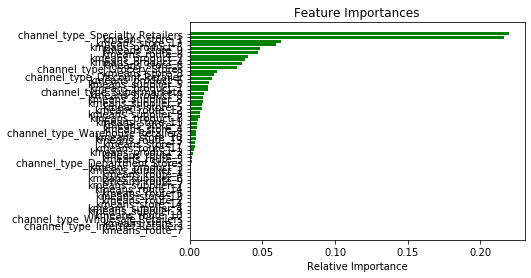

In [68]:
importances = clf.feature_importances_
indices = np.argsort(importances)
print(indices)

features = X_train.columns

plt.title('Feature Importances')
plt.barh(range(len(indices)),importances[indices], color='g')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Fit regression model
params = {'n_estimators': 51, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf2 = ensemble.GradientBoostingRegressor(**params)

In [ ]:
clf2.fit(X_train, y_train)

In [ ]:
rmse = sqrt(mean_squared_error(y_train, clf2.predict(X_train)))
print("Train RMSE: %.4f" % rmse)
rmse = sqrt(mean_squared_error(y_val, clf2.predict(X_val)))
print("Test RMSE: %.4f" % rmse)

In [ ]:
#================END================

Try including the price columns

In [ ]:
traindata.isnull().sum()

experiment_week                0
channel_type                   0
demand_projection              0
kmeans_store                   0
kmeans_product                 0
kmeans_route                   0
kmeans_supplier                0
num_units_sold_in_week         0
sales_revenue_in_week          0
num_units_returned             0
returned_units_revenue_loss    0
dtype: int64

In [ ]:
train.head()

,channel_type,demand_projection,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier,num_units_sold_in_week,sales_revenue_in_week,num_units_returned,returned_units_revenue_loss
0,Grocery Stores,65,11,9,1,1,65,4387.500000,0,0.000000
2,Grocery Stores,9,8,9,4,9,9,1262.250000,0,0.000000
3,Grocery Stores,5,11,9,1,1,5,583.500000,0,0.000000
5,Grocery Stores,4,11,6,2,5,4,360.000000,0,0.000000
7,Grocery Stores,2,11,2,10,1,2,225.000000,0,0.000000


Price of each unit = sales revenue/num of units sold

In [ ]:
train['price_of_each_unit'] = train.sales_revenue_in_week/train.num_units_sold_in_week

In [ ]:
val['price_of_each_unit'] = val.sales_revenue_in_week/val.num_units_sold_in_week

Checking for null values

In [ ]:
train.isnull().sum() #*100/len(traindata)

channel_type                       0
demand_projection                  0
kmeans_store                       0
kmeans_product                     0
kmeans_route                       0
kmeans_supplier                    0
num_units_sold_in_week             0
sales_revenue_in_week              0
num_units_returned                 0
returned_units_revenue_loss        0
price_of_each_unit             15801
dtype: int64

Filling the null values to 0

In [ ]:
train.fillna(0, inplace= True)

In [ ]:
val.fillna(0, inplace= True)

In [ ]:
train.columns

Index(['channel_type', 'demand_projection', 'kmeans_store', 'kmeans_product',
       'kmeans_route', 'kmeans_supplier', 'num_units_sold_in_week',
       'sales_revenue_in_week', 'num_units_returned',
       'returned_units_revenue_loss', 'price_of_each_unit'],
      dtype='object')

In [ ]:
X_train = train.drop(['demand_projection','num_units_sold_in_week', 'sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss'],axis = 1)
y_train = train['demand_projection']
X_val = val.drop(['demand_projection','num_units_sold_in_week', 'sales_revenue_in_week', 'num_units_returned','returned_units_revenue_loss'],axis = 1)
y_val = val['demand_projection']
for i in X_train.columns.difference(['price_of_each_unit']):
  X_train[i] = X_train[i].astype('category')
for i in X_val.columns.difference(['price_of_each_unit']):
  X_val[i] = X_val[i].astype('category')

X_train = pd.get_dummies(data=X_train,drop_first=True)
print(X_train.shape)

X_val = pd.get_dummies(data=X_val,drop_first=True)
print(X_val.shape)


(4295788, 54)
(1040700, 54)


Decision tree regressor for prediction

In [ ]:
regressor = DecisionTreeRegressor() 
regressor.fit(X_train, y_train) 
y_pred = regressor.predict(X_train)
rms = sqrt(mean_squared_error(y_train, y_pred))
print(rms)
y_val_pred = regressor.predict(X_val)
rms_val = sqrt(mean_squared_error(y_val, y_val_pred))
print(rms_val)

11.234407823378296
18.23117859415205


In [ ]:
rmse = sqrt(mean_squared_error(y_train, clf2.predict(X_train)))
print("RMSE: %.4f" % rmse)


RMSE: 18.8633


In [ ]:
rmse = sqrt(mean_squared_error(y_val, clf2.predict(X_val)))
print("RMSE: %.4f" % rmse)

RMSE: 22.7120


## <a name=8>Test Data Predictions<a/>
<a href=#0>(Go to Contents)<a/>

#### Import test data

In [ ]:
test=pd.read_csv('/content/gdrive/My Drive/test.csv')

#### Perform feature engineering on test data
Replace the non-numerical columns with their respective kmeans clusters

In [ ]:
merged_test_df = pd.merge(test, kmeans_store,  how='left', left_on='store_identifier', right_on = 'label')
merged_test_df.head(2)

,id,experiment_week,channel_type,supplier_identifier,category_of_route,store_identifier,product_identifier,label,kmeans_store
0,1,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_cbfad,store_fc6aa,0.0
1,2,Week 6 of 2019,Warehouse Retailers,supplier_identifier_055f7,route_67047,store_fc6aa,product_2b363,store_fc6aa,0.0


In [ ]:
merged_test_df = merged_test_df.drop(['store_identifier','label'], axis = 1)
merged_test_df = pd.merge(merged_test_df, kmeans_product,  how='left', left_on='product_identifier', right_on = 'label')
merged_test_df = merged_test_df.drop(['product_identifier','label'], axis = 1)
merged_test_df = pd.merge(merged_test_df, kmeans_route,  how='left', left_on='category_of_route', right_on = 'label')
merged_test_df = merged_test_df.drop(['category_of_route','label'], axis = 1)
merged_test_df = pd.merge(merged_test_df, kmeans_supplier,  how='left', left_on='supplier_identifier', right_on = 'label')
merged_test_df = merged_test_df.drop(['supplier_identifier','label'], axis = 1)
merged_test_df.head(2)

,id,experiment_week,channel_type,kmeans_store,kmeans_product,kmeans_route,kmeans_supplier
0,1,Week 6 of 2019,Warehouse Retailers,0.0,5.0,9.0,0
1,2,Week 6 of 2019,Warehouse Retailers,0.0,6.0,9.0,0


In [ ]:
merged_test_df.dtypes

id                   int64
experiment_week     object
channel_type        object
kmeans_store       float64
kmeans_product     float64
kmeans_route       float64
kmeans_supplier      int64
dtype: object

In [ ]:
merged_test_df.columns

Index(['id', 'experiment_week', 'channel_type', 'kmeans_store',
       'kmeans_product', 'kmeans_route', 'kmeans_supplier'],
      dtype='object')

In [ ]:
X_test = merged_test_df.drop(['experiment_week'],axis = 1)

Getting the categorical columns to change the datatypes appropriately

In [ ]:
test_cat_columns = ['channel_type', 'kmeans_store',
       'kmeans_product', 'kmeans_route', 'kmeans_supplier']

In [ ]:
for i in test_cat_columns:
  X_test[i] = X_test[i].astype('category')

In [ ]:
X_test.dtypes

id                    int64
channel_type       category
kmeans_store       category
kmeans_product     category
kmeans_route       category
kmeans_supplier    category
dtype: object

In [ ]:
X_test = pd.get_dummies(data=X_test,drop_first=True)

In [ ]:
X_test.shape

(20815581, 54)

In [ ]:
X_test.head(2)

,id,channel_type_Department Stores,channel_type_Discount Retailer,channel_type_Grocery Stores,channel_type_Internet Retailers,channel_type_Specialty Retailers,channel_type_Supermarkets,channel_type_Warehouse Retailers,channel_type_Wholesale Retailers,kmeans_store_1.0,kmeans_store_2.0,kmeans_store_3.0,kmeans_store_4.0,kmeans_store_5.0,kmeans_store_6.0,kmeans_store_7.0,kmeans_store_8.0,kmeans_store_9.0,kmeans_store_10.0,kmeans_store_11.0,kmeans_store_12.0,kmeans_store_13.0,kmeans_store_14.0,kmeans_product_1.0,kmeans_product_2.0,kmeans_product_3.0,kmeans_product_4.0,kmeans_product_5.0,kmeans_product_6.0,kmeans_product_7.0,kmeans_product_8.0,kmeans_product_9.0,kmeans_route_2.0,kmeans_route_3.0,kmeans_route_4.0,kmeans_route_5.0,kmeans_route_6.0,kmeans_route_7.0,kmeans_route_8.0,kmeans_route_9.0,kmeans_route_10.0,kmeans_route_11.0,kmeans_route_12.0,kmeans_route_13.0,kmeans_route_14.0,kmeans_supplier_1,kmeans_supplier_2,kmeans_supplier_3,kmeans_supplier_4,kmeans_supplier_5,kmeans_supplier_6,kmeans_supplier_7,kmeans_supplier_8,kmeans_supplier_9
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Preserving the 'id' column for later use in submission file**

In [ ]:
ID = X_test['id']

In [ ]:
X_test.drop('id',inplace=True, axis = 1)

In [ ]:
X_test.columns

Index(['channel_type_Department Stores', 'channel_type_Discount Retailer',
       'channel_type_Grocery Stores', 'channel_type_Internet Retailers',
       'channel_type_Specialty Retailers', 'channel_type_Supermarkets',
       'channel_type_Warehouse Retailers', 'channel_type_Wholesale Retailers',
       'kmeans_store_1.0', 'kmeans_store_2.0', 'kmeans_store_3.0',
       'kmeans_store_4.0', 'kmeans_store_5.0', 'kmeans_store_6.0',
       'kmeans_store_7.0', 'kmeans_store_8.0', 'kmeans_store_9.0',
       'kmeans_store_10.0', 'kmeans_store_11.0', 'kmeans_store_12.0',
       'kmeans_store_13.0', 'kmeans_store_14.0', 'kmeans_product_1.0',
       'kmeans_product_2.0', 'kmeans_product_3.0', 'kmeans_product_4.0',
       'kmeans_product_5.0', 'kmeans_product_6.0', 'kmeans_product_7.0',
       'kmeans_product_8.0', 'kmeans_product_9.0', 'kmeans_route_2.0',
       'kmeans_route_3.0', 'kmeans_route_4.0', 'kmeans_route_5.0',
       'kmeans_route_6.0', 'kmeans_route_7.0', 'kmeans_route_8.0',
       '

In [ ]:
X_train.columns

Index(['channel_type_Department Stores', 'channel_type_Discount Retailer',
       'channel_type_Grocery Stores', 'channel_type_Internet Retailers',
       'channel_type_Specialty Retailers', 'channel_type_Supermarkets',
       'channel_type_Warehouse Retailers', 'channel_type_Wholesale Retailers',
       'kmeans_store_1', 'kmeans_store_2', 'kmeans_store_3', 'kmeans_store_4',
       'kmeans_store_5', 'kmeans_store_6', 'kmeans_store_7', 'kmeans_store_8',
       'kmeans_store_9', 'kmeans_store_10', 'kmeans_store_11',
       'kmeans_store_12', 'kmeans_store_13', 'kmeans_store_14',
       'kmeans_product_1', 'kmeans_product_2', 'kmeans_product_3',
       'kmeans_product_4', 'kmeans_product_5', 'kmeans_product_6',
       'kmeans_product_7', 'kmeans_product_8', 'kmeans_product_9',
       'kmeans_route_2', 'kmeans_route_3', 'kmeans_route_4', 'kmeans_route_5',
       'kmeans_route_6', 'kmeans_route_7', 'kmeans_route_8', 'kmeans_route_9',
       'kmeans_route_10', 'kmeans_route_11', 'kmeans_rout

In [ ]:
X_test.shape

(20815581, 53)

**Predicting for demand projection of test data**

In [ ]:
ypred_test = clf.predict(X_test)

In [ ]:
len(ypred_test)

20815581

In [ ]:
len(ID)

20815581

In [ ]:
pred = np.array(ypred_test)

In [ ]:
id1 = np.array(ID)

In [ ]:
dataset = pd.DataFrame({'id': id1,'demand_projection': pred}, columns=['id', 'demand_projection'])

In [ ]:
dataset.head(4)

,id,demand_projection
0,1,7.971458
1,2,7.971458
2,3,7.971458
3,4,7.971458


In [ ]:
dataset.tail(4)

,id,demand_projection
20815577,20815578,6.534076
20815578,20815579,6.534076
20815579,20815580,6.534076
20815580,20815581,6.534076


#### Test Predictions Submission files

In [ ]:
dataset.to_csv("final_sub.csv", index=False)


In [ ]:
dataset2 = dataset.copy()

To decrease the file size, restricting the decimal places

In [ ]:
dataset2['demand_projection'] = dataset2['demand_projection'].round(decimals = 0)

In [ ]:
dataset2.head(2)

,id,demand_projection
0,1,8.0
1,2,8.0


In [ ]:
dataset2.to_csv("final_sub2.csv", index=False)